# Pruebas con la librería __Torch__


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

- Cargamos los datasets

In [3]:
# Bajamos los datos de entrenamiento del conjunto de datos abierto.
datos_entrenamiento = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Bajamos los datos de test del conjunto de datos abierto.
datos_test = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

clases = [
    "Camiseta/top",
    "Pantalón",
    "Jersey",
    "Vestido",
    "Abrigo",
    "Sandalia",
    "Camisa",
    "Zapatillas",
    "Bolso",
    "Botín",
]

dispositivo = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Usando {dispositivo} como dispositivo")

Usando cuda como dispositivo


- Examinamos el `dataset` y sus `items`

Nº de items del dataset: 60000
Tipo del item: <class 'tuple'>
Dimensiones de la tupla: 2
Tipo del item[0]: <class 'torch.Tensor'>
Dimensiones del tensor item[0]: torch.Size([1, 28, 28])
Tipo de dato del tensor item[0]: torch.float32
Tipo de dispositivo donde esta almacenado el tensor item[0]: cpu
Tipo de dispositivo donde esta almacenado el tensor 'tensor': cuda:0
Tipo del item[1]: <class 'int'>
Valor de item[1]: 0 - Camiseta/top


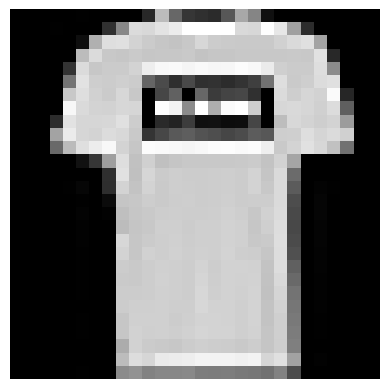

In [7]:
def mostrar_imagen(imagen_mostrar):
    # Mostrar imagen
    plt.imshow(imagen_mostrar, cmap="gray")
    plt.axis("off")
    plt.show()

n = len(datos_entrenamiento)
print(f"Nº de items del dataset: {n}")
item = datos_entrenamiento[1]
tensor = item[0].to(dispositivo)
print(f"Tipo del item: {type(item)}")
print(f"Dimensiones de la tupla: {len(item)}")
print(f"Tipo del item[0]: {type(item[0])}")
print(f"Dimensiones del tensor item[0]: {item[0].shape}")
print(f"Tipo de dato del tensor item[0]: {item[0].dtype}")
print(f"Tipo de dispositivo donde esta almacenado el tensor item[0]: {item[0].device}")
print(f"Tipo de dispositivo donde esta almacenado el tensor 'tensor': {tensor.device}")
print(f"Tipo del item[1]: {type(item[1])}")
print(f"Valor de item[1]: {item[1]} - {clases[item[1]]}")

# Cambiar el orden de los ejes a H x W x C para Matplotlib
image_tensor = item[0].permute(1, 2, 0)

mostrar_imagen(image_tensor)

- Cargar el `dataset`al `dataloader`

Dimensiones de X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Dimensiones de y: torch.Size([64]) torch.int64


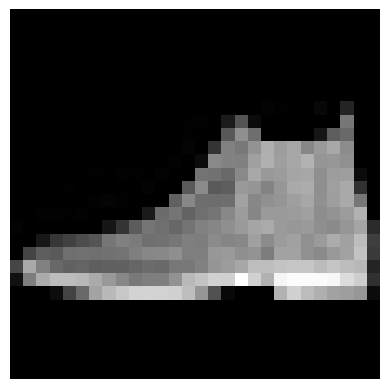

In [8]:
tamanho_batch = 64

# Creamos los data loaders.
train_dataloader = DataLoader(datos_entrenamiento, batch_size=tamanho_batch)
test_dataloader = DataLoader(datos_test, batch_size=tamanho_batch)



for X, y in test_dataloader:
    print(f"Dimensiones de X [N, C, H, W]: {X.shape}")
    print(f"Dimensiones de y: {y.shape} {y.dtype}")
    image_tensor = X[0, :, :, :].permute(1, 2, 0)
    mostrar_imagen(image_tensor)
    break

- Definimos la red neuronal

In [10]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

modelo = NeuralNetwork().to(dispositivo)
print(modelo)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


- Definimos la _funcion de pérdida_ y el _optimizador_.

In [11]:
funcion_perdida = nn.CrossEntropyLoss()
optimizador = torch.optim.SGD(modelo.parameters(), lr=1e-3)

- Definimos el bucle de entrenamiento

In [12]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Calculamos el error de predicción
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"perdida: {loss:>7f}  [{current:>5d}/{size:>5d}]")

- Definimos el bucle de _test_

In [13]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Precisión: {(100*correct):>0.1f}%, perdida media: {test_loss:>8f} \n")

- Ejecutamos las épocas

In [ ]:
epocas = 5
for t in range(epocas):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, modelo, funcion_perdida, optimizador)
    test(test_dataloader, modelo, funcion_perdida)
print("Done!")

- Guardamos el modelos en disco

In [ ]:
torch.save(modelo.state_dict(), "modelo.pth")
print("Guardado el 'PyTorch Model State' en modelo.pth")

- Cargamos el modelo de disco

In [15]:
model = NeuralNetwork().to(dispositivo)
model.load_state_dict(torch.load("modelo.pth", weights_only=True))

<All keys matched successfully>

- Hacemos predicciones sobre el modelo

In [20]:
model.eval()
x, y = datos_test[0][0], datos_test[0][1]
with torch.no_grad():
    x = x.to(dispositivo)
    pred = model(x)
    predicted, actual = clases[pred[0].argmax(0)], clases[y]
    print(f'Predicho: "{predicted}", Real: "{actual}"')
    print(pred)

Predicho: "Botín", Real: "Botín"
tensor([[-3.9287, -5.4405, -2.0929, -2.3425, -1.6020,  5.0782, -1.8001,  4.5368,
          2.7817,  5.3729]], device='cuda:0')
